In [190]:
%matplotlib widget
import casadi as ca
import numpy as np
from src.opti_mpc_utils import plot_results 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.close("all")


# Create an Opti instance
opti = ca.Opti()

# Solver options


p_opts = {
    "expand":True,
    "print_time": 0,
    "verbose": False,
    "error_on_fail": True,
}
# s_opts = {'max_iter':1000, "warm_start_init_point": "yes","print_level":0}
s_opts = {}
opti.solver("ipopt",p_opts,
                    s_opts)

#=========== Define the Horizon ============
N = 24 # 2min
Ts = 5  
zs = 3; # leave room for max three lags for inital conditions

#============= Tank Model ==================
# x = [Qin, h, Qout]
# y = [h, Qout]
A = 18
F = np.array([[1,0,0],[Ts/A,1,-Ts/A],[0, 0, 1]])
C = np.array([[0,1,0],[0, 0, 1]])



#=========== Parameters of the static models
B1_pressure = np.array([9.2727E-05])
B2_pressure = np.array([2.5979E-08])
C_pressure = np.array([5.3955E-01])



#=========== Parameters of the ARX model
# array of params
A_outflow = np.array([1.1493E-01, 3.5884E-07, -2.9890E-07, -8.4661E-02, 7.5640E-04,
                    -3.8695E-04, 3.9287E-04, -6.8566E-07, -1.5757E-04, 1.0592E-03,
                    2.7095E-07, -4.1301E-01, 7.0157E-05]).reshape((1,-1))

A_power = np.hstack([np.diag([1.6108E-01, 3.6872E-03, 2.3590E-01]), np.diag([9.5030E-02, 3.1648E-03, 1.9355E-01])])
# A_pressure = 5.5858E-05


B_power = np.diag([3.5117E-02, 4.1216E-02, 2.7095E-02])

C_power = np.array([0, 0, 1.5144E-03]).reshape((3,-1))

#=========== Desired value of y 
Qout_meas = opti.parameter(zs)   # ascending index: older data, at 0: last measured value (t-1)
Qin_est = opti.parameter(N+zs)
h_ref = opti.parameter(N+zs)
w_meas =  opti.parameter(3,zs)

h_meas = opti.parameter(zs)
E_meas = opti.parameter(3,zs)
P_meas = opti.parameter(zs)

trigger = opti.parameter(3) # Trigger constant over entire horizon

#=========== Declare Symbolic Variables
Qout = opti.variable(N+zs)
E = opti.variable(3,N+zs)
P = opti.variable(N+zs)
w = opti.variable(3,N+zs)
h = opti.variable(N+zs)
effi = opti.variable(N+zs)

#============= Slack Variables
s_h = opti.variable(N+zs)
s_P = opti.variable(N+zs)
s_w = opti.variable(3) # Trigger slack constant over entire horizon


#=========== Objective function
objective = 0

for t in range(zs, N+zs):
    dw = w[:,t]-w[:,t-1]
    # objective +=  0*((E[:,t].T @ E[:,t])/(Qout[t]+0.0001))**2 + 0.0000000001 *((dw.T)@ dw)   +  1*(h[t]-h_ref[t])**2  + 10*s_P[t]**2 + 0.00000000000000001*(s_w[:].T @ s_w[:])
    objective += 1*(h[t]-h_ref[t])**2 + 0 *((dw.T)@ dw) + 1000*s_P[t]**2 + 1000*s_h[t]**2  + (s_w[:].T @ s_w[:])#1*(s_w[0]+s_w[1]+s_w[2])

opti.minimize(objective)   


# ARX model constraints
for t in range(zs, N+zs):   
    opti.subject_to(Qout[t] ==ca.if_else( 
                                w[0,t-1] <= 600,
                                3.2216 + 0.08378681 * w[0,t-1],  # First segment equation
                                3.22 + 0.083 * 600 + 0.8371 * (w[0,t-1] - 600),  # Second segment equation, ensuring continuity at the breakpoint
                                True) 
                            + ca.if_else(
                                w[1,t-1] <= 600,
                                3.2216 + 0.08378681 * w[1,t-1],  # First segment equation
                                3.22 + 0.083 * 600 + 0.8371 * (w[1,t-1] - 600),  # Second segment equation, ensuring continuity at the breakpoint
                                True)
                            + ca.if_else(
                                w[2,t-1] <= 600,
                                3.2216 + 0.08378681 * w[2,t-1],  # First segment equation
                                3.22 + 0.083 * 600 + 0.8371 * (w[2,t-1] - 600),  # Second segment equation, ensuring continuity at the breakpoint
                                True))


    opti.subject_to(E[:,t] == A_power @ ca.vcat([E[:,t-1],E[:,t-2]]) + B_power @ w[:,t-1] + C_power)

    opti.subject_to(P[t] == B1_pressure @ Qout[t] + B2_pressure @ Qout[t]**2 + C_pressure) 
      
    opti.subject_to(h[t] == h[t-1] + Ts/3600*(Qin_est[t-1]-Qout[t-1])/A)

for t in range(0, N+zs):
    opti.subject_to(effi[t] == (E[0,t]+E[1,t]+E[2,t])/(Qout[t]+0.0001))



# Additional constraints (e.g., on control input)
for t in range(zs, N+zs):
    opti.subject_to(w[:,t] >= 0)  # Lower bound on control input
    
    opti.subject_to(w[:,t] <= ca.fmin(1500*trigger[:]+s_w[:],1500))

    opti.subject_to(h[t] <= (200 + s_h[t]))
    opti.subject_to(h[t] >= (120 - s_h[t]))
    opti.subject_to(P[t] <= (1 + s_P[t]))  # upper bound on pressure
    opti.subject_to(P[t] >= (0 - s_P[t]))  # lower bound on pressure

    # Slack Variables need to be constrained to positive values
    opti.subject_to(s_h[t] >= 0)
    opti.subject_to(s_P[t] >= 0)

opti.subject_to(s_w[:] >= 0)



# Initial conditions
opti.subject_to(Qout[0:zs]   == Qout_meas)  # Initial value of y, read from sensor
opti.subject_to(h[0:zs]      == h_meas)
opti.subject_to(w[:,0:zs]    == w_meas)  
opti.subject_to(P[0:zs]      == P_meas)
opti.subject_to(E[:,0:zs]      == E_meas)


# TODO: Is it possible to remove this? If ommited, exception due to undefined parameters
opti.set_value(Qin_est,0)
opti.set_value(Qout_meas,[0,0,0])
opti.set_value(h_meas,[0,0,0])
opti.set_value(w_meas,np.vstack([[0,0,0],[0,0,0],[0,0,0]]).reshape(3,-1)) 

opti.set_value(E_meas,np.vstack([[0,0,0],[0,0,0],[0,0,0]]).reshape(3,-1))
opti.set_value(P_meas,[0,0,0])

opti.set_value(trigger,[1,0,0]) # Select enabled pumps
opti.set_value(h_ref,150)


In [191]:

# Add Qin
inputs = [Qin_est,Qout_meas,h_meas,w_meas,E_meas,P_meas,trigger,h_ref]
outputs = [w,Qout,h,E,P,effi]
mpc_controller = opti.to_function("mpc_controller",inputs,outputs)



In [192]:
# =================== History Initialization ===================
# ==== Last element[-1]: latest; first[0]: oldest
h_hist = [190,190,195]
w_hist = np.vstack([[1000,1100,1200],[0,0,0],[0,0,0]]).reshape(3,-1)
Qout_hist = [317,314,315]
E_hist = np.vstack([[0,0,0],[0,0,0],[0,0,0]]).reshape(3,-1)
P_hist = [1,0.9,0.8]
effi_hist = [0,0,0]


trigger_k = [1,0,0]
# building some trajectory for Qin estimation
Qin_k = np.hstack([[300,300,300],np.arange(300, 3000, 200/Ts), np.ones(10000)*3000])
Qin_hist = Qin_k[0:zs]

# building some trajectory for height reference
h_ref_k = np.hstack([[150,150,150],np.arange(150, 145, (149-150)/(N+zs)), np.ones(10000)*145]) 
h_ref_hist = h_ref_k[0:zs] # history of reference for plotting, href_k cant be plotted because time horizon 

In [193]:
# =================== Measurement Updates and appending ===================

for k in range(100):
    print(f"iteration : {k}")
    sol_w,sol_Qout,sol_h,sol_E,sol_P,sol_effi = mpc_controller(Qin_k[k:N+k+zs],Qout_hist[-3:],h_hist[-3:],w_hist[:,-3:],E_hist[:,-3:],P_hist[-3:],trigger_k,h_ref_k[k:N+k+zs])
        
    h_meas_k = sol_h[zs].full().reshape(1)
    # h_hist = np.hstack([h_hist[1:], h_meas_k])
    h_hist = np.hstack([h_hist, h_meas_k])

    w_meas_k = sol_w[:,zs].full()
    # w_hist = np.hstack([w_hist[:,1:], w_meas_k])
    w_hist = np.hstack([w_hist, w_meas_k])

    Qout_meas_k = sol_Qout[zs].full().reshape(1)
    # Qout_hist = np.hstack([Qout_hist[1:], Qout_meas_k])
    Qout_hist = np.hstack([Qout_hist, Qout_meas_k])  

    E_meas_k = sol_E[:,zs].full()
    # E_hist = np.hstack([E_hist[:,1:], E_meas_k])  
    E_hist = np.hstack([E_hist, E_meas_k])   

    P_meas_k = sol_P[zs].full().reshape(-1)
    # P_hist = np.hstack([P_hist[1:], P_meas_k])  
    P_hist = np.hstack([P_hist, P_meas_k]) 

    effi_k = sol_effi[zs].full().reshape(-1)
    effi_hist = np.hstack([effi_hist, effi_k])   

    h_ref_hist = np.hstack([h_ref_hist, h_ref_k[k+zs]])   
    
    Qin_hist = np.hstack([Qin_hist, Qin_k[k+zs]])   

    trigger_k = [1,0,0]




iteration : 0
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      666
Number of nonzeros in inequality constraint Jacobian.:      459
Number of nonzeros in Lagrangian Hessian.............:      255

Total number of variables............................:      327
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      198
Total number of inequality constraints...............:      291
        inequality constraints with only lower bounds:      123
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      168

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.3693926e+05 1.20e+03 1.00e+02  -1.0 0.00e+00    -  0.00

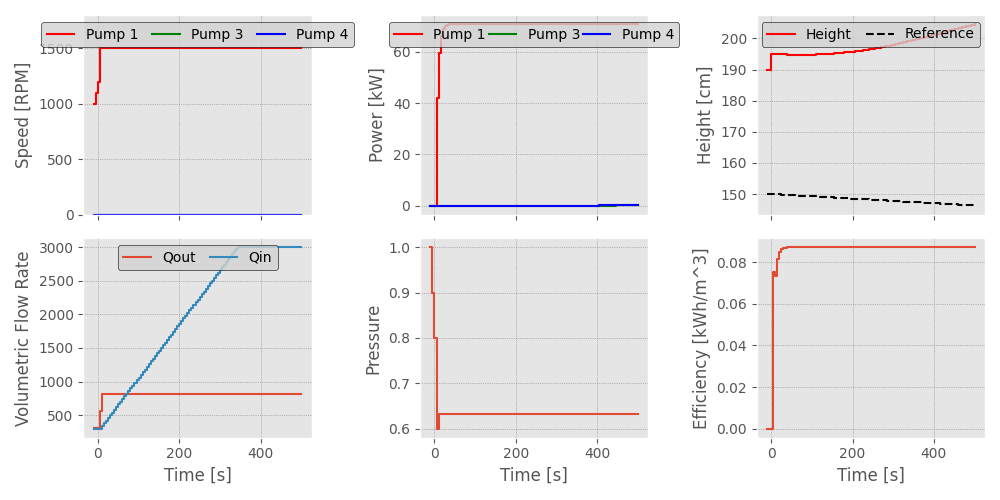

In [194]:
time = np.arange((-zs+1)*Ts, (w_hist.shape[1]-zs+1)*Ts, Ts)
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=False)

# Plot 1 - Speed [RPM]
axs[0, 0].step(time,w_hist[0, :], "r", label='Pump 1',where='post')
axs[0, 0].step(time,w_hist[1, :], "g", label='Pump 3',where='post')
axs[0, 0].step(time,w_hist[2, :], "b", label='Pump 4',where='post')
axs[0, 0].set_ylim([0, 1800])
axs[0, 0].set_ylabel('Speed [RPM]')
axs[0, 0].grid(linestyle=':', linewidth='0.5', color='gray')
axs[0, 0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')


# Plot 2 - Power [kW]
axs[0, 1].step(time,E_hist[0, :], "r", label='Pump 1',where='post')
axs[0, 1].step(time,E_hist[1, :], "g", label='Pump 3',where='post')
axs[0, 1].step(time,E_hist[2, :], "b", label='Pump 4',where='post')
axs[0, 1].set_ylabel('Power [kW]')
axs[0, 1].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[0, 1].set_ylim([0, 150])
axs[0, 1].legend(loc='upper center', columnspacing=0.2, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 3 - Height
axs[0, 2].step(time,h_hist, "r", label='Height',where='post')
axs[0, 2].step(time,h_ref_hist, "k--", label='Reference',where='post')
axs[0, 2].set_ylabel("Height [cm]")
axs[0, 2].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[0, 2].set_ylim([0, 250])
axs[0, 2].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 4 - Volumetric Flow Rate
axs[1, 0].step(time,Qout_hist, label='Qout',where='post')
axs[1, 0].step(time,Qin_hist, label='Qin',where='post')
axs[1, 0].set_ylabel("Volumetric Flow Rate")
axs[1, 0].set_xlabel("Time [s]")
axs[1, 0].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[1, 0].set_ylim([0, 800])
axs[1, 0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 5 - Pressure
axs[1, 1].step(time,P_hist, label='Pressure',where='post')
axs[1, 1].set_ylabel("Pressure")
axs[1, 1].set_xlabel("Time [s]")
axs[1, 1].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[1, 1].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 6 - effi
axs[1, 2].step(time,effi_hist, label='Qout',where='post')
# axs[1, 2].step([0,N],[sol.value(s_w[0]),sol.value(s_w[0])], label='s_w 1')
# axs[1, 2].step([0,N],[sol.value(s_w[1]),sol.value(s_w[1])], label='s_w 1')
# axs[1, 2].step([0,N],[sol.value(s_w[2]),sol.value(s_w[2])], label='s_w 1')
axs[1, 2].grid(linestyle=':', linewidth='0.5', color='gray')
axs[1, 2].set_ylabel("Efficiency [kWh/m^3]")
axs[1, 2].set_xlabel("Time [s]")
# axs[1, 2].set_ylim([0, 1500])
# axs[1, 2].legend(loc='upper center', columnspacing=0.5, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

plt.tight_layout()
plt.show()


In [195]:
# time = np.arange((-zs+1)*Ts, (N+1)*Ts, Ts)
# fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=False)

# # Plot 1 - Speed [RPM]
# axs[0, 0].step(time,sol_w[0, :].full().reshape(-1,1), "r", label='Pump 1',where='post')
# axs[0, 0].step(time,sol_w[1, :].full().reshape(-1,1), "g", label='Pump 3',where='post')
# axs[0, 0].step(time,sol_w[2, :].full().reshape(-1,1), "b", label='Pump 4',where='post')
# # axs[0, 0].set_ylim([0, 1700])
# axs[0, 0].set_ylabel('Speed [RPM]')
# axs[0, 0].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[0, 0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')


# # Plot 2 - Power [kW]
# axs[0, 1].step(time,sol_E[0, :].full().reshape(-1,1), "r", label='Pump 1',where='post')
# axs[0, 1].step(time,sol_E[1, :].full().reshape(-1,1), "g", label='Pump 3',where='post')
# axs[0, 1].step(time,sol_E[2, :].full().reshape(-1,1), "b", label='Pump 4',where='post')
# axs[0, 1].set_ylabel('Power [kW]')
# axs[0, 1].grid(linestyle=':', linewidth='0.5', color='gray')
# # axs[0, 1].set_ylim([0, 150])
# axs[0, 1].legend(loc='upper center', columnspacing=0.2, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# # Plot 3 - Height
# axs[0, 2].step(time,sol_h.full().reshape(-1,1), "r", label='Height',where='post')
# axs[0, 2].step(time,h_ref_k.reshape(-1,1), "k--", label='Reference',where='post')
# axs[0, 2].set_ylabel("Height [cm]")
# axs[0, 2].grid(linestyle=':', linewidth='0.5', color='gray')
# # axs[0, 2].set_ylim([0, 250])
# axs[0, 2].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# # Plot 4 - Volumetric Flow Rate
# axs[1, 0].step(time,sol_Qout.full().reshape(-1,1), label='Qout',where='post')
# axs[1, 0].step(time,Qin_hist.reshape(-1,1), label='Qin',where='post')
# axs[1, 0].set_ylabel("Volumetric Flow Rate")
# axs[1, 0].set_xlabel("Time [s]")
# axs[1, 0].grid(linestyle=':', linewidth='0.5', color='gray')
# # axs[1, 0].set_ylim([0, 800])
# axs[1, 0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# # Plot 5 - Pressure
# axs[1, 1].step(time,sol_P.full().reshape(-1,1), label='Pressure',where='post')
# axs[1, 1].set_ylabel("Pressure")
# axs[1, 1].set_xlabel("Time [s]")
# axs[1, 1].grid(linestyle=':', linewidth='0.5', color='gray')
# # axs[1, 1].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# # Plot 6 - effi
# axs[1, 2].step(time,sol_effi.full().reshape(-1,1), label='Qout',where='post')
# # axs[1, 2].step([0,N],[sol.value(s_w[0]),sol.value(s_w[0])], label='s_w 1')
# # axs[1, 2].step([0,N],[sol.value(s_w[1]),sol.value(s_w[1])], label='s_w 1')
# # axs[1, 2].step([0,N],[sol.value(s_w[2]),sol.value(s_w[2])], label='s_w 1')
# axs[1, 2].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[1, 2].set_ylabel("Efficiency [kWh/m^3]")
# axs[1, 2].set_xlabel("Time [s]")
# # axs[1, 2].set_ylim([0, 1500])
# # axs[1, 2].legend(loc='upper center', columnspacing=0.5, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# plt.tight_layout()
# plt.show()
